In [1]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import sys
import matplotlib
import matplotlib.pyplot as plt
from skimage.color import lab2rgb
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
import skimage
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from functools import reduce
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from scipy import stats

In [2]:
def to_timestamp(dateTime):
    return dateTime.timestamp()

def map_genre(row):
   result = []
   for genre_code in row:
       matches = genres[genres['wikidata_id'] == genre_code]['genre_label'].values
       for match in matches:
           result.append(match)
   return result

In [3]:
wikidata = pd.read_json('movies/data/wikidata-movies.json.gz', orient='record', lines=True, encoding="utf8", convert_dates=['publication_date'])
genres = pd.read_json('movies/data/genres.json.gz', orient='record', lines=True, encoding="utf8")

In [4]:
wikidata = wikidata[wikidata['made_profit'].notnull()].reset_index(drop=True)
wikidata['publication_timestamp'] = wikidata['publication_date'].apply(to_timestamp)
wikidata['genre_names'] = wikidata['genre'].apply(map_genre)

In [5]:
rotten_tomatoes = pd.read_json('movies/data/rotten-tomatoes.json.gz', orient='record', lines=True)
omdb = pd.read_json('movies/data/omdb-data.json.gz', orient='record', lines=True)
combined = wikidata.join(rotten_tomatoes.set_index('rotten_tomatoes_id'), on='rotten_tomatoes_id', rsuffix='_rt')
combined = combined.join(omdb.set_index('imdb_id'), on='imdb_id')

In [6]:
combined

,based_on,cast_member,country_of_origin,director,enwiki_title,filming_location,genre,imdb_id,label,made_profit,...,genre_names,audience_average,audience_percent,audience_ratings,critic_average,critic_percent,imdb_id_rt,omdb_awards,omdb_genres,omdb_plot
0,NaN,"[Q5126010, Q3390414, Q5676024, Q237021]",Q29,[Q51892574],Orbiter 9,NaN,"[Q24925, Q21010853]",tt3469798,Orbiter 9,0.0,...,"[science fiction, drama]",3.1,41.0,60.0,5.5,60.0,tt3469798,2 nominations.,"[Drama, Romance, Sci-Fi]",Helena is a young girl who spent all her life ...
1,NaN,NaN,Q30,"[Q3384479, Q351884]",Despicable Me,NaN,[Q157443],tt1323594,Despicable Me,1.0,...,[comedy film],NaN,NaN,NaN,NaN,NaN,tt1323594,Nominated for 1 Golden Globe. Another 3 wins &...,"[Animation, Adventure, Comedy]",In a happy suburban neighborhood surrounded by...
2,NaN,"[Q386349, Q1605965, Q3805579, Q271162, Q463226...",Q30,[Q2071],Eraserhead,[Q99],"[Q130232, Q200092, Q5967378]",tt0074486,Eraserhead,1.0,...,"[drama film, horror film, speculative fiction]",3.9,83.0,57175.0,8.3,91.0,tt0074486,2 wins & 1 nomination.,[Horror],A film that defies conventional logic and stor...
3,Q17017426,"[Q117500, Q1376880, Q11930, Q311169, Q951634, ...",Q30,[Q11930],Dances with Wolves,[Q1558],"[Q130232, Q369747, Q21590660, Q21010853, Q319221]",tt0099348,Dances with Wolves,1.0,...,"[drama film, war film, Western, drama, adventu...",3.6,87.0,213360.0,7.5,82.0,tt0099348,Won 7 Oscars. Another 43 wins & 37 nominations.,"[Adventure, Drama, Western]",Lt. John Dunbar is dubbed a hero after he acci...
4,NaN,"[Q38111, Q211553, Q177311, Q8927, Q173399, Q20...",Q145,[Q25191],Inception,"[Q99, Q387047, Q17, Q90, Q1951, Q7275217, Q126...","[Q496523, Q471839, Q2484376, Q188473, Q319221]",tt1375666,Inception,1.0,...,"[heist film, science fiction film, thriller fi...",4.2,91.0,568239.0,8.1,86.0,tt1375666,Won 4 Oscars. Another 152 wins & 204 nominations.,"[Action, Adventure, Sci-Fi]","Dom Cobb is a skilled thief, the absolute best..."
5,NaN,"[Q229313, Q445772, Q727988, Q3163137, Q1372392...",Q16,[Q6385039],Mama (2013 film),"[Q172, Q133116, Q13939]",[Q200092],tt2023587,Mama,1.0,...,[horror film],3.4,55.0,143566.0,6.0,65.0,tt2023587,11 wins & 18 nominations.,"[Horror, Thriller]","The senior partner of an investment brokerage,..."
6,Q243556,"[Q34012, Q41163, Q95043, Q464714, Q171736, Q32...",Q30,[Q56094],The Godfather,"[Q18438, Q60, Q1408, Q1460]","[Q130232, Q959790, Q7444356, Q21010853, Q52162...",tt0068646,The Godfather,1.0,...,"[drama film, crime film, gangster film, drama,...",4.4,98.0,731426.0,9.3,98.0,tt0068646,Won 3 Oscars. Another 24 wins & 28 nominations.,"[Crime, Drama]",When the aging head of a famous crime family d...
7,NaN,"[Q483118, Q23547, Q108283, Q215072, Q270664, Q...",Q30,[Q483118],Argo (2012 film),"[Q406, Q65, Q43]","[Q622291, Q18620604]",tt1024648,Argo,1.0,...,"[political thriller, dramatization]",4.2,90.0,207900.0,8.4,96.0,tt1024648,Won 3 Oscars. Another 94 wins & 152 nominations.,"[Biography, Drama, Thriller]","In 1979, the American embassy in Iran was inva..."
8,Q7857661,"[Q317343, Q57147, Q244674, Q343616, Q208649, Q...",Q145,[Q706475],12 Years a Slave (film),[Q34404],"[Q130232, Q645928, Q52162262]",tt2024544,12 Years a Slave,1.0,...,"[drama film, biographical film, film based on ...",4.3,90.0,139374.0,8.9,96.0,tt2024544,Won 3 Oscars. Another 235 wins & 326 nominations.,"[Biography, Drama, History]",Based on an incredible true story of one man's...
9,NaN,"[Q295803, Q200534, Q228865, Q200405, Q314133, ...",Q145,[Q191755],Only Lovers Left Alive,"[Q183, Q365]","[Q130232, Q1054574, Q2137852]",tt1714915,Only Lovers Left Alive,1.0,...,"[drama film, romance film, vampire film]",3.8,75.0,21114.0,7.4,85.0,tt1714915,9 wins & 42 nominations.,"[Comedy, Drama, Fantasy]","Adam (Tom Hiddleston), an underground musician..."


# Is there a difference between the positivity of critics and the audience?

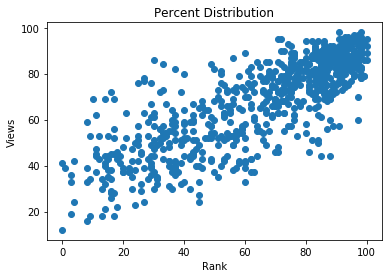

In [7]:
plt.title('Percent Distribution')
plt.xlabel('Rank')
plt.ylabel('Views')
plt.scatter(combined['critic_percent'], combined['audience_percent'])
plt.show()

In [8]:
test3 = combined[combined['audience_percent'].notnull() & combined['critic_percent'].notnull()]
print(stats.normaltest(test3['audience_percent']).pvalue) #<0.05, therefore not normal
print(stats.mannwhitneyu(test3['critic_percent'], test3['audience_percent']).pvalue) #>0.05, therefore equal
print(test3['audience_percent'].mean())
print(test3['critic_percent'].mean())

3.608996083927233e-17
0.4397286644629225
68.09782608695652
65.06657608695652


# Have average ratings changed over time?

In [9]:
critic_average_test = combined[['publication_date','publication_timestamp','critic_average']].dropna()
fit = stats.linregress(critic_average_test['publication_timestamp'], critic_average_test['critic_average'])
critic_average_test['prediction'] = critic_average_test['publication_timestamp']*fit.slope + fit.intercept
print(fit.pvalue) #p < 0.05, therefore we can conclude that critic ratings are decreasing.
print(fit.rvalue) #correlation coefficient is low, so it is not very correlated

6.156831173958277e-08
-0.19792833987738837


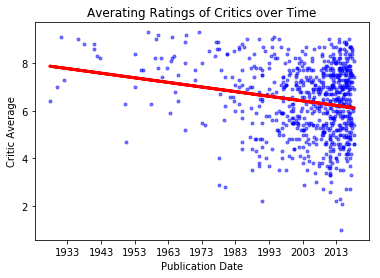

In [44]:
plt.title('Averating Ratings of Critics over Time')
plt.xlabel('Publication Date')
plt.ylabel('Critic Average')
plt.plot(critic_average_test['publication_date'], critic_average_test['critic_average'], 'b.', alpha=0.5)
plt.plot(critic_average_test['publication_date'], critic_average_test['prediction'], 'r-', linewidth=3)
plt.show()

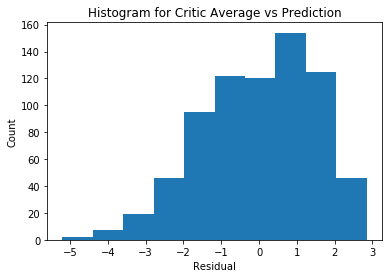

In [51]:
plt.title('Histogram for Critic Average vs Prediction')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.hist(np.subtract(critic_average_test['critic_average'],critic_average_test['prediction']))
plt.show()
#By the central limit theorem, this is close enough to being normal.
#We expect a greater decline on the high end because the average critic rating is higher than the middle rating, 5.

In [12]:
audience_average_test = combined[['publication_date','publication_timestamp','audience_average']].dropna()
fit = stats.linregress(audience_average_test['publication_timestamp'], audience_average_test['audience_average'])
audience_average_test['prediction'] = audience_average_test['publication_timestamp']*fit.slope + fit.intercept
print(fit.pvalue) #p > 0.05, therefore we cannot conclude that the audience ratings are changing.
print(fit.rvalue) #correlation coefficient is low, so it is not very correlated

0.20019655801512012
0.046244255512890686


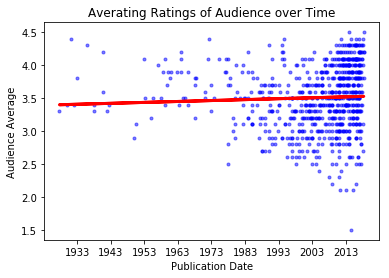

In [45]:
plt.title('Averating Ratings of Audience over Time')
plt.xlabel('Publication Date')
plt.ylabel('Audience Average')
plt.plot(audience_average_test['publication_date'], audience_average_test['audience_average'], 'b.', alpha=0.5)
plt.plot(audience_average_test['publication_date'], audience_average_test['prediction'], 'r-', linewidth=3)
plt.show()

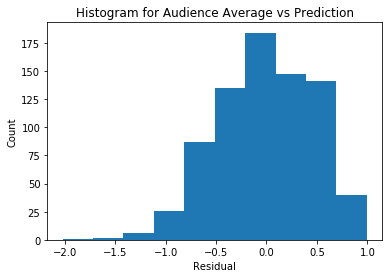

In [52]:
plt.title('Histogram for Audience Average vs Prediction')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.hist(np.subtract(audience_average_test['audience_average'],audience_average_test['prediction']))
plt.show()
#By the central limit theorem, this is close enough to being normal.
#We expect a greater decline on the high end because the average audience rating is higher than the middle rating, 2.5.

# Do average audience ratings change based on its popularity?

In [15]:
audience_ratings_test = combined[['publication_date','publication_timestamp','audience_average','audience_ratings']].dropna()
#Removing movies with n >= 10000000 ratings as they seem like outliers
audience_ratings_test = audience_ratings_test[audience_ratings_test['audience_ratings'] < 10000000]
fit = stats.linregress(audience_ratings_test['audience_ratings'], audience_ratings_test['audience_average'])
audience_ratings_test['prediction'] = audience_ratings_test['audience_ratings']*fit.slope + fit.intercept
print(fit.pvalue) #p < 0.05, therefore we can conclude that higher averages correlate with more popular movies.
print(fit.rvalue) #correlation coefficient is low, so it is not very correlated

0.000308565324974134
0.13095968100108196


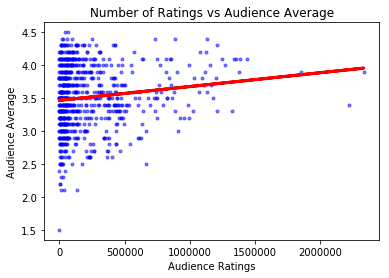

In [46]:
plt.title('Number of Ratings vs Audience Average')
plt.xlabel('Audience Ratings')
plt.ylabel('Audience Average')
plt.plot(audience_ratings_test['audience_ratings'], audience_ratings_test['audience_average'], 'b.', alpha=0.5)
plt.plot(audience_ratings_test['audience_ratings'], audience_ratings_test['prediction'], 'r-', linewidth=3)
plt.show()

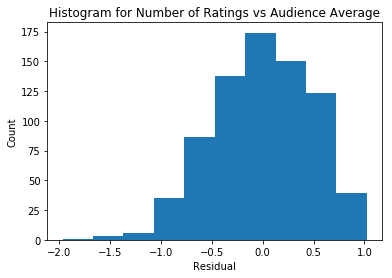

In [49]:
plt.title('Histogram for Number of Ratings vs Audience Average')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.hist(np.subtract(audience_ratings_test['audience_average'],audience_ratings_test['prediction']))
plt.show()
#By the central limit theorem, this is close enough to being normal.
#We expect a greater decline on the high end because the average audience rating is higher than the middle rating, 2.5.

# Does genre have an effect on profitability?

In [18]:
def genre_profit_agg(combined_row):
    for genre_id in combined_row['genre']:
        genre_test.loc[genre_test['wikidata_id'] == genre_id,'total']+=1
        if (combined_row['made_profit'] == 1.0):
            genre_test.loc[genre_test['wikidata_id'] == genre_id,'profit']+=1

In [19]:
genre_test = genres
genre_test['profit'] = 0
genre_test['total'] = 0
combined.apply(genre_profit_agg, axis=1)
genre_test = genre_test[genre_test['total'] > 0]

In [20]:
genre_test['loss'] = genre_test['total'] - genre_test['profit']
genre_test = genre_test[genre_test['profit'] >= 5]
genre_test = genre_test[genre_test['loss'] >= 5]
contingency = genre_test[['profit','loss']]
#contingency = contingency[contingency['profit'] >= 5]
#contingency = contingency[contingency['loss'] >= 5]
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(p) # p < 0.05, therefore genre effects profitability

0.01956332775267009


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
genre_test['avg'] = genre_test['profit']/genre_test['total']
genre_test.sort_values(by='avg',ascending=False).reset_index(drop=True)
#Science fiction films are the most profitable.

,genre_label,wikidata_id,profit,total,loss,avg
0,science fiction film,Q471839,130,142,12,0.915493
1,romantic comedy,Q860626,53,59,6,0.898305
2,romance film,Q1054574,44,49,5,0.897959
3,horror film,Q200092,70,78,8,0.897436
4,war film,Q369747,40,45,5,0.888889
5,thriller film,Q2484376,108,122,14,0.885246
6,film based on literature,Q52162262,119,135,16,0.881481
7,adventure film,Q319221,104,119,15,0.873950
8,fantasy film,Q157394,109,125,16,0.872000
9,comedy film,Q157443,162,189,27,0.857143


# Does country of origin have an effect on profitability?

In [22]:
countries = pd.DataFrame(columns=['country_id', 'made_profit'])
#countries.loc[len(countries)] = ['Q123',1.0]

def add_country_profit(combined_row):
    countries.loc[len(countries)] = [combined_row['country_of_origin'], combined_row['made_profit']]
    return

combined_with_countries = combined[combined['country_of_origin'].notnull()]
combined_with_countries.apply(add_country_profit, axis=1)
countries_groupby = countries.groupby(['country_id'])
countries_avg = countries_groupby.mean()
countries_count = countries_groupby.count()
countries_sum = countries_groupby.sum()
countries_stats = countries_avg
countries_stats['total'] = countries_count
countries_stats['sum'] = countries_sum
countries_stats = countries_stats.reset_index()
countries_stats.columns = ['country_id','percent','total','profit']
countries_stats['loss'] = countries_stats['total'] - countries_stats['profit']
#countries_stats = countries_stats[countries_stats['profit'] > 5]
#countries_stats = countries_stats[countries_stats['loss'] > 5]
countries_stats = countries_stats[countries_stats['total'] > 5]

In [23]:
contingency = countries_stats[['profit','loss']]
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(p) # p < 0.05, therefore country effects profitability

0.008871929501706175


In [24]:
countries_stats.sort_values(by='percent',ascending=False).reset_index(drop=True) #Country Q30, presumably the US, is the best country to make a movie in for profit

,country_id,percent,total,profit,loss
0,Q16,0.875000,8,7.0,1.0
1,Q30,0.860465,602,518.0,84.0
2,Q142,0.838710,31,26.0,5.0
3,Q145,0.838710,62,52.0,10.0
4,Q159,0.677419,31,21.0,10.0
5,Q408,0.636364,11,7.0,4.0
6,Q183,0.625000,16,10.0,6.0


# Does cast member have an effect on profitability?

In [25]:
cast = pd.DataFrame(columns=['cast_id', 'made_profit'])

def add_cast_profit(combined_row):
    for cast_member in combined_row['cast_member']:
        cast.loc[len(cast)] = [cast_member, combined_row['made_profit']]
    return

combined_with_cast = combined[combined['cast_member'].notnull()]
combined_with_cast.apply(add_cast_profit, axis=1)
cast_groupby = cast.groupby(['cast_id'])

In [26]:
cast_avg = cast_groupby.mean()
cast_count = cast_groupby.count()
cast_sum = cast_groupby.sum()
cast_stats = cast_avg
cast_stats['total'] = cast_count
cast_stats['sum'] = cast_sum
cast_stats = cast_stats.reset_index()
cast_stats.columns = ['cast_id','percent','total','profit']
cast_stats['loss'] = cast_stats['total'] - cast_stats['profit']
cast_stats = cast_stats[cast_stats['total'] > 5]
cast_stats

,cast_id,percent,total,profit,loss
7,Q102124,0.833333,6,5.0,1.0
20,Q103157,0.636364,11,7.0,4.0
41,Q104061,1.000000,7,7.0,0.0
55,Q104791,0.666667,6,4.0,2.0
84,Q1060758,0.833333,6,5.0,1.0
98,Q106706,1.000000,6,6.0,0.0
107,Q10738,0.500000,6,3.0,3.0
159,Q110374,1.000000,8,8.0,0.0
184,Q112536,1.000000,6,6.0,0.0
193,Q113206,1.000000,7,7.0,0.0


In [27]:
contingency = cast_stats[['profit','loss']]
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(p) # p > 0.05, therefore cast effects doesn't effect profitability.

0.21051014915423152


# How well can we predict profitability based on ratings?

In [28]:
predict_profit = combined
predict_profit = predict_profit[predict_profit['critic_average'].notnull()]
predict_profit = predict_profit[predict_profit['audience_average'].notnull()]
predict_profit = predict_profit[predict_profit['critic_percent'].notnull()]
predict_profit = predict_profit[predict_profit['audience_percent'].notnull()]
predict_profit = predict_profit.reset_index(drop=True)
X = predict_profit[['critic_average','audience_average','critic_percent','audience_percent']]
y = predict_profit['made_profit']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y)
model = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=20000)
)
model.fit(X_train, y_train)
print(model.score(X_test, y_test)) #0.8+ score, so pretty well
#model.fit(X, y)

0.8260869565217391


# Can we predict things based on genre? (nope)
I didn't realise that X needs to be floats... gg what a waste of time T_T

In [29]:
#def genre_average_rating_agg(combined_row):
#    for genre_id in combined_row['genre']:
#        genre_test.loc[genre_test['wikidata_id'] == genre_id,'total']+=1
#        genre_test.loc[genre_test['wikidata_id'] == genre_id,'total_aud_avg']+=combined_row['audience_average']
#        genre_test.loc[genre_test['wikidata_id'] == genre_id,'total_cri_avg']+=combined_row['critic_average']
#        if (combined_row['made_profit'] == 1.0):
#            genre_test.loc[genre_test['wikidata_id'] == genre_id,'profit']+=1

In [30]:
#combined_no_nan_ratings = combined[combined['critic_average'].notnull()]
#combined_no_nan_ratings = combined_no_nan_ratings[combined_no_nan_ratings['audience_average'].notnull()].reset_index(drop=True)
#genre_test = genres
#genre_test['profit'] = 0
#genre_test['total_aud_avg'] = 0
#genre_test['total_cri_avg'] = 0
#genre_test['total'] = 0
#combined.apply(genre_average_rating_agg, axis=1)
#genre_test = genre_test[genre_test['total'] > 0]

In [31]:
#genre_test.loc[:,'aud_avg'] = genre_test['total_aud_avg']/genre_test['total']
#genre_test.loc[:,'cri_avg'] = genre_test['total_cri_avg']/genre_test['total']
#Dont know about the SettingWithCopyWarning, can probably just ignore since it is just a warning

In [32]:
#genre_test = genre_test.reset_index(drop=True)
#X = genre_test.drop(columns=['aud_avg','cri_avg','profit','total','total_aud_avg','total_cri_avg','genre_label'])
#y = genre_test['aud_avg']

#X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y)
#model = make_pipeline(
#    StandardScaler(),
#    SVC(kernel='rbf', C=20000)
#)
#model.fit(X_train, y_train)
#print(model.score(X_test, y_test))
#model.fit(X, y)


# NATURAL LANGUAGE PROCESSING WORK HERE

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(test3["omdb_plot"])

In [35]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [36]:
from sklearn.naive_bayes import MultinomialNB
y=test3["audience_average"]
y=y.astype('int')
clf = MultinomialNB().fit(X_train_tfidf, y)

In [37]:
docs_new = ['The']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)
predicted = clf.predict(X_new_tfidf)

In [38]:
for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, test3["omdb_plot"][category])) #not working?

'The' => Lt. John Dunbar is dubbed a hero after he accidentally leads Union troops to a victory during the Civil War. He requests a position on the western frontier, but finds it deserted. He soon finds out he is not alone, but meets a wolf he dubs "Two-socks" and a curious Indian tribe. Dunbar quickly makes friends with the tribe, and discovers a white woman who was raised by the Indians. He gradually earns the respect of these native people, and sheds his white-man's ways.


In [39]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(test3["omdb_plot"])
feature = vectorizer.get_feature_names()
vocab = np.array(feature)

In [40]:
feature #list of key words extracted

['000',
 '007',
 '04',
 '10',
 '100',
 '1000',
 '100th',
 '101',
 '10s',
 '10th',
 '11',
 '1100',
 '1101',
 '117',
 '12',
 '120',
 '1200',
 '127',
 '12th',
 '13',
 '1357',
 '13th',
 '14',
 '140',
 '15',
 '155',
 '15th',
 '16',
 '1621',
 '163',
 '1630',
 '16th',
 '17',
 '170',
 '1776',
 '1790s',
 '18',
 '1823',
 '1839',
 '1848',
 '1860',
 '1863',
 '1865',
 '1868',
 '1890',
 '1890s',
 '1899',
 '1912',
 '1914',
 '1918',
 '1920s',
 '1926',
 '1930',
 '1930s',
 '1939',
 '1940',
 '1941',
 '1942',
 '1944',
 '1945',
 '1946',
 '1950',
 '1950s',
 '1955',
 '1956',
 '1957',
 '1958',
 '1959',
 '1960',
 '1960s',
 '1961',
 '1962',
 '1963',
 '1964',
 '1967',
 '1968',
 '1969',
 '1970',
 '1970s',
 '1971',
 '1972',
 '1976',
 '1977',
 '1979',
 '1980',
 '1980s',
 '1982',
 '1984',
 '1987',
 '1990s',
 '1991',
 '1993',
 '1994',
 '1996',
 '19th',
 '1st',
 '20',
 '200',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2009',
 '2010',
 '2012',
 '2014',
 '2018',
 '2019',
 '2029',
 '2054',
 '2058',
 '2093',


In [41]:
doc = 0
feature_index = tfidf_matrix[doc,:].nonzero()[1]
tfidf_scores = zip(feature_index, [tfidf_matrix[doc, x] for x in feature_index])

In [42]:
for w, s in [(feature[i], s) for (i, s) in tfidf_scores]:
  print (w, s) #showing tfidf score for each word in the summary

helena 0.44994830287228665
is 0.0313254157653011
young 0.034445749219816774
girl 0.04124583321382185
who 0.04117339272962841
spent 0.06110947647223666
all 0.08785899163498494
her 0.1305810708682046
life 0.028510313451956933
in 0.07483826251551558
space 0.27166123481520066
pod 0.1433487708116238
just 0.03935140526206201
after 0.0556949649512731
birth 0.06110947647223666
traveling 0.056434429793391354
from 0.09141913017567936
earth 0.08753467605892976
to 0.11319755553481937
distant 0.06368234032073075
planet 0.10741769474075274
where 0.03410825925872209
she 0.09254048288700302
will 0.057020626903913865
reunite 0.0669993387269666
with 0.07183623067344654
others 0.05370884737037637
colonials 0.07966643049089307
the 0.2263242798960254
voice 0.06522196846906535
of 0.07819068208685259
on 0.019475290305502265
board 0.06522196846906535
computer 0.056434429793391354
as 0.04303063239856396
only 0.03226771030131625
one 0.027529829222765145
company 0.051015248556804275
arriving 0.07499138381204777
